In [1]:
colors = ['cloudy blue', 'dark pastel green', 'dust', 'electric lime', 'fresh green', 'light eggplant', 'nasty green',
       'really light blue', 'tea', 'warm purple', 'yellowish tan', 'cement', 'dark grass green', 'dusty teal', 'grey teal',
       'macaroni and cheese', 'pinkish tan', 'spruce', 'strong blue', 'toxic green', 'windows blue', 'blue blue', 
       'blue with a hint of purple', 'booger', 'bright sea green', 'dark green blue', 'deep turquoise', 'green teal',
       'strong pink', 'bland']
for c in range(0, len(colors)):
    colors[c] = 'xkcd:' + colors[c]

In [2]:
# (1) import data from json files
# (2) generate: full data (X), labels (y), and class weights (wgt)

# import data
import numpy as np
import json

# Change .json filename to select animal ID number

# import standard experiment data (XS) and metadata (S_labels)
with open('data/pyData/2705_Data_S_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XS = pxx.reshape(a*b, c).T
S_labels = data[1]

# import lidocaine experiment data (XL) and metadata (L_labels)
with open('data/pyData/2705_Data_L_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XL = pxx.reshape(a*b, c).T
L_labels = data[1]

# import cholinergic receptor antagonist experiment data (XC) and metadata (C_labels)
with open('data/pyData/2705_Data_C_Notch14_1.json') as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XC = pxx.reshape(a*b, c).T
C_labels = data[1]

wght = {2: 2., 0: 9., 1: 18.}
y = []

cID = [] # data indices from cholinergic antagonist data set (dataC)
for k in np.arange(0,len(C_labels['allWindows']['subject'])):
    if (int('hm' in C_labels['allWindows']['subject'][k]) and C_labels['allWindows']['stimOn'][k]):
        # hexamethonium condition (muscle signal only) during stimulation is labeled 0, weight 9
        cID.append(k)
        y.append(0)
    elif (int('hm' in C_labels['allWindows']['subject'][k]) and C_labels['allWindows']['baseline'][k]):
        # hexamethonium condition (muscle signal only) during baseline is labeled 0, weight 9
        cID.append(k)
        y.append(0)
    elif (int('ae' in C_labels['allWindows']['subject'][k]) and C_labels['allWindows']['stimOn'][k]):
        # atropine condition (neuron signal only) during stimulation is labeled 1, weighted 18
        cID.append(k)
        y.append(1)
    elif (int('ae' in C_labels['allWindows']['subject'][k]) and C_labels['allWindows']['baseline'][k]):
        # hexamethonium condition (muscle signal only) during baseline is labeled 0, weight 9
        cID.append(k)
        y.append(0)
        
sID = [] # data indices from standard experiment data set (dataS)
for k in np.arange(0,len(S_labels['allWindows']['subject'])):
    if S_labels['allWindows']['stimOn'][k]:
        # standard experiment (both muscle and neuron) during stimulation is labeled 2, weighted 1
        sID.append(k)
        y.append(2)
    elif S_labels['allWindows']['baseline'][k]:
        # hexamethonium condition (muscle signal only) during baseline is labeled 0, weight 9
        sID.append(k)
        y.append(0)

X = np.concatenate((XC[cID], XS[sID]), axis=0) # generate data set (X) from individual json files based on ID's
X_all = np.concatenate((XC, XS, XL), axis=0)

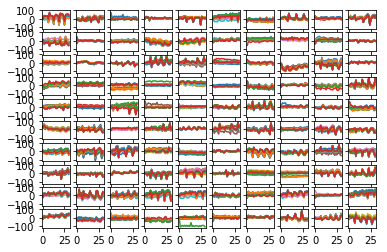

In [3]:
# convert data into frequency (scores) and component profiles (factors) from ICA

from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

C = 100 # number of features
testID = np.zeros(((len(cID) + len(sID))), dtype = 'int')
testID[range(0, len(cID))] = cID
for s in range(0, len(sID)):
    testID[s + len(cID)] = int(sID[s] + len(C_labels['allWindows']['subject']))
    
ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
scores = ica.fit_transform(X_all) #pull components from ica fit transformation
scoreClass = scores[testID]
factors = ica.mixing_
factors = factors.reshape(a, b, C)

I = 10
J = 10

f0, ax = plt.subplots(I, J, sharex = True, sharey = True) #Build a better subplot matrix
for i in range(0, I):
    for j in range(0, J):
        if i*I+j < factors.shape[2]:
            ax[i, j].plot(S_labels['f'], factors[:, :, i*I+j])

plt.show()

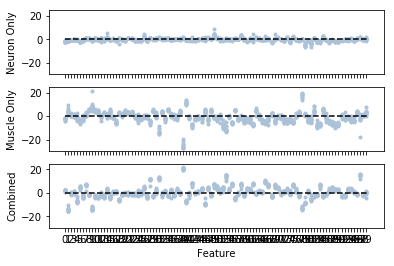

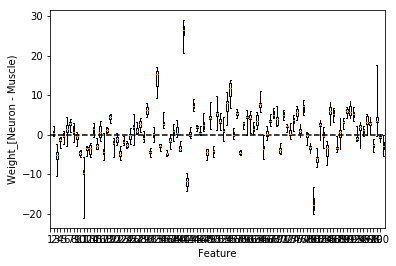

In [5]:
# (1) split scores and labels into training and testing groups
# (2) plot data as boxplots, and difference of the weights between neuron and muscle

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.metrics import roc_curve, auc

n = 10 # number of folds
F = 1 # number of sets of folds


nrn_data = [[] for _ in range(C)]
msc_data = [[] for _ in range(C)]
cmb_data = [[] for _ in range(C)]

f1 = plt.figure()
f2 = plt.figure()

for fld in range(0,F):
    coef = np.zeros((n, 3, C))
    i = 0
    skf = StratifiedKFold(n_splits = n, shuffle = True)    
    for train_index, test_index in skf.split(scoreClass, y):
        X_train, X_test = scoreClass[train_index], scoreClass[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        clf = svm.SVC(kernel = 'linear', class_weight = wght, probability = True)
        y_score = clf.fit(X_train, y_train).decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc.append(auc(fpr, tpr))
        plt.plot(fpr, tpr, lw = 1.5)
        coef[i, :, :] = clf.coef_    
        i = i + 1
        coeff_diff = [[] for _ in range(0, C)]   
        
        plt.figure(f1.number)
        plt.plot(fpr, tpr, lw = 1.5)
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(np.mean(roc_auc))

    for cmp in range(0, C):
        nrn_data[cmp] = coef[:, 1, cmp]
        msc_data[cmp] = coef[:, 0, cmp]
        cmb_data[cmp] = coef[:, 2, cmp]
        coeff_diff[cmp].append(nrn_data[cmp]-msc_data[cmp])
    
    plt.figure(f2.number)
    plt.boxplot(coeff_diff, whis = 'range')
    plt.xlabel('Feature')
    plt.ylabel('Weight_[Neuron - Muscle)')
    plt.xticks(np.arange(0, C))
    plt.plot([0, C], [0, 0], color = 'k', linestyle = '--')

    plt.show()

xkcd:dark pastel green
xkcd:warm purple
xkcd:strong blue


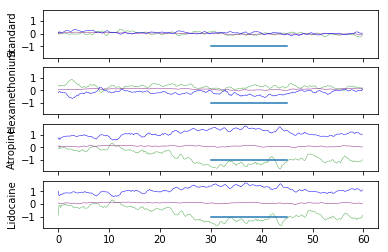

In [6]:
bxData = [[] for _ in range(0, 9)]
coefAvg = np.mean(coef, axis = 0)
target = np.matmul(scores, coefAvg.T)

f00, ax = plt.subplots(4, 1, sharex = True, sharey = True)
clr = [1, 9, 18]
for i in range(0, len(clr)):
    print(colors[clr[i]])

S_pred, Hx_pred, At_pred, L_pred = np.zeros((3, 9, 360)), np.zeros((3, 3, 360)), np.zeros((3, 3, 360)), np.zeros((3, 3, 360))
# indices are Predictor [Msc, Nrn, Both], Trial [0, 3 or 9], and wID [0, 360]


for i in range(0, len(C_labels['allWindows']['windowID'])):
    w = C_labels['allWindows']['windowID'][i]-1
    if w < 360:
        d = int(C_labels['allWindows']['subject'][i][6])-1
        if int('hm' in C_labels['allWindows']['subject'][i]):
            Hx_pred[:, d, w] = target[i]
        elif int('ae' in C_labels['allWindows']['subject'][i]):
            At_pred[:, d, w] = target[i]

for i in range(0, len(S_labels['allWindows']['subject'])):
    w = S_labels['allWindows']['windowID'][i]-1
    if w < 360:
        d = int(S_labels['allWindows']['subject'][i][6])-1
        S_pred[:, d, w] = target[i]
        
for i in range(0, len(L_labels['allWindows']['subject'])):
    if 'lS' in L_labels['allWindows']['subject'][i]:
        w = L_labels['allWindows']['windowID'][i]-1
        if w < 360:
            d = int(L_labels['allWindows']['subject'][i][6])-1
            L_pred[:, d, w] = target[i]
            
N = 5
wd = np.arange(0,360-N+1)+(N-2)
pred = [S_pred, Hx_pred, At_pred, L_pred]
mean = [[], [], [], []]

for grp in range(0, 4):
    mean[grp] = [[], [], []]
    for p in range(0, 3):
        for d in range(0, pred[grp].shape[1]):
            cumsum, moving_aves = [0], []
            for i, x in enumerate(pred[grp][p, d, :], 1):
                cumsum.append(cumsum[i-1] + x)
                if i>=N:
                    moving_ave = (cumsum[i] - cumsum[i-N])/N
                    moving_aves.append(moving_ave)
            pred[grp][p, d, wd]=moving_aves
        mean[grp][p] = np.mean(pred[grp][p, :, :], axis = 0)
        
t = np.arange(0, 360)
ylab = ['Standard', 'Hexamethonium', 'Atropine', 'Lidocaine']
for grp in range(0, 4):
    for p in range(0, 3):
        ax[grp].plot(t/6, mean[grp][p], color = colors[clr[p]],
                 lw = 0.5, linestyle = '-')
    ax[grp].set_ylabel(ylab[grp])
    ax[grp].plot([30, 45], [-1, -1])
plt.show()

C:\Users\Bradley Barth\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\scipy\stats\stats.py:2967: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


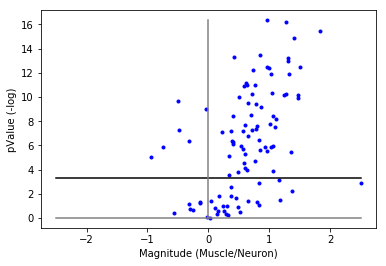

0.11701003732 0.149444047596
0.537745645474 1.21084258716e-06
0.345277419408 6.9624458157e-06
0.523379053569 0.334988230201
0.655550527829 0.0364768639727
0.377923178747 6.84103192109e-08
0.310854525834 0.0970974409154
0.243618740548 0.0997347130773
0.966401439909 3.5121845424e-13
1.05852987772 1.18702133373e-06
0.724209143368 5.43699737783e-11
1.09835728382 2.93272753664e-08
-0.132720721639 0.0523657452652
0.795570052147 2.67808564705e-08
-0.245627250741 0.236163754625
1.02589872028 1.27035809479e-06
0.609938819918 4.86792913578e-06
0.768890571794 9.47799651778e-12
1.06589966545 0.000134480444849
1.16048836303 0.000742070582447
0.634828120003 1.02624307261e-11
0.384068559086 4.43224584187e-07
0.695918736435 3.07246201534e-09
-0.309574548872 0.172562496339
0.448346441206 0.0236501583145
0.372151821918 0.00279307408242
-0.949829429146 9.02277267303e-06
-0.323137394014 0.0749351742342
0.728067228817 5.49141340418e-13
1.49921653602 3.36512569339e-13
0.0227149604335 0.956023858118
0.998467

In [8]:
# conduct one-way ANOVA on coeff_diff (neuron-muscle) data set

import scipy.stats as stats

fc = 1
coeff = {'0': []}

tukey_data = []
tukey_grp = []
for cmp in range(0, C):
    coeff[str(cmp)] = coeff_diff[cmp]
    for i in range(0,len(coeff_diff[cmp])):
        tukey_data.append(coeff_diff[cmp][i])
        tukey_grp.append(cmp)

stats.f_oneway(*coeff.values())

pval = np.zeros((C, 1))
mag = []
for cmp in range(0, C): 
    t, pval[cmp] = stats.ttest_ind(nrn_data[cmp], msc_data[cmp])
    mag.append(np.log10(np.abs(np.mean(msc_data[cmp])) / np.abs(np.mean(nrn_data[cmp]))))

plt.figure()
plt.plot(mag, -np.log10(pval), marker = '.', linestyle = '', color = 'b')
ex = np.max(np.abs(mag))
plt.plot([-ex, ex], -np.log10([0.05/C, 0.05/C]), color = 'k')
plt.plot([0, 0], [0, np.max(-np.log10(pval))], color = 'gray')
plt.plot([-ex, ex], [0, 0], color = 'gray')
plt.xlabel('Magnitude (Muscle/Neuron)')
plt.ylabel('pValue (-log)')
plt.show()

for cmp in range(0, C):print(mag[cmp], pval[cmp][0])

M = (pval.T < (0.05/C)) * (np.array(mag) > fc)
N = (pval.T < (0.05/C)) * (np.array(mag) < -fc)

profiles = {'M': np.arange(0, C)[M[0]], 'N': np.arange(0, C)[N[0]]}

C:\Users\Bradley Barth\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


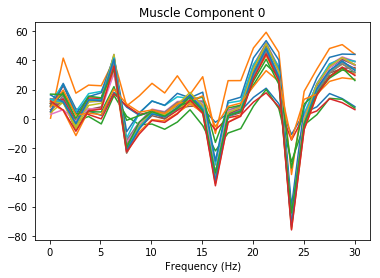

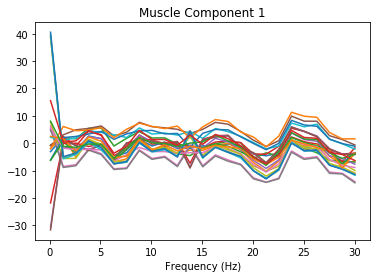

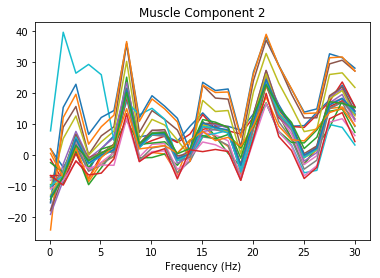

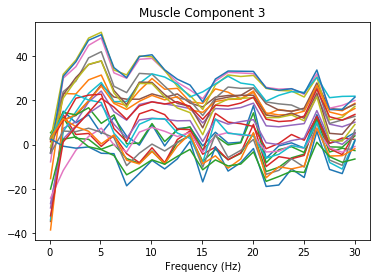

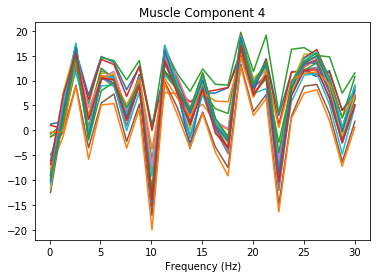

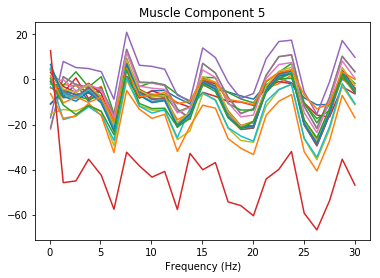

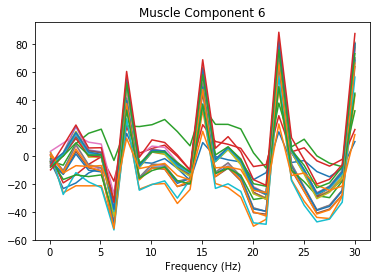

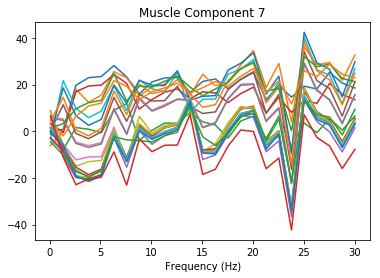

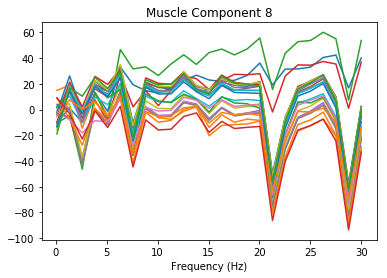

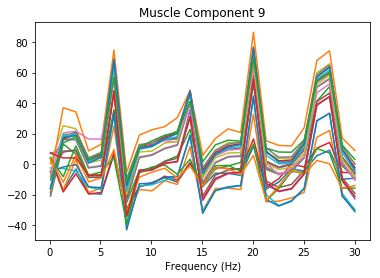

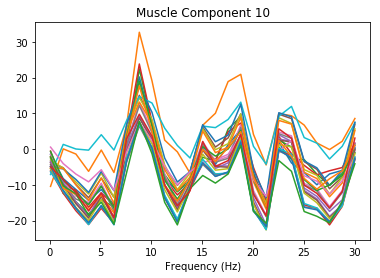

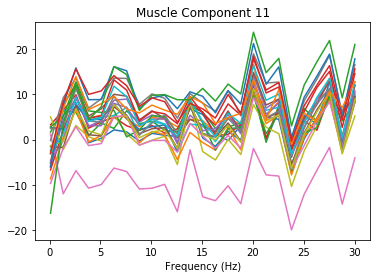

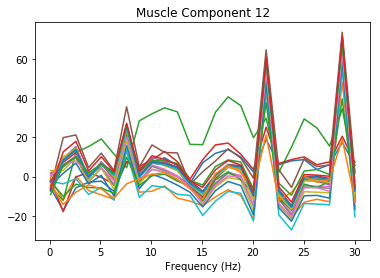

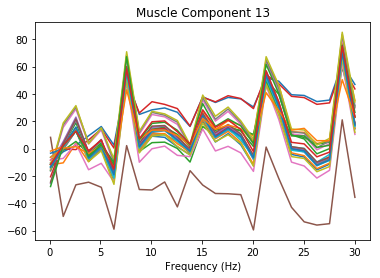

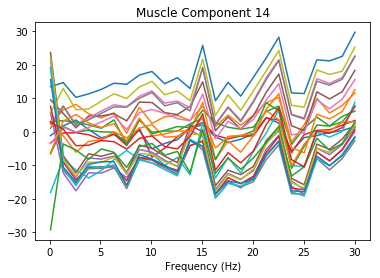

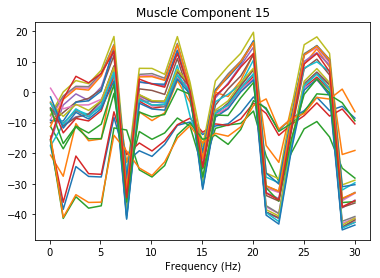

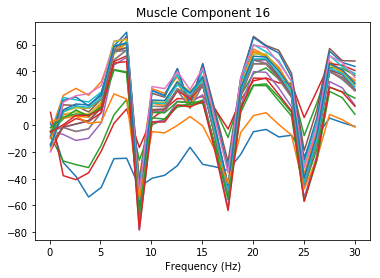

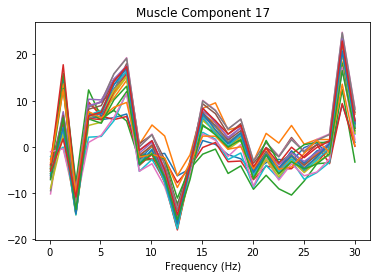

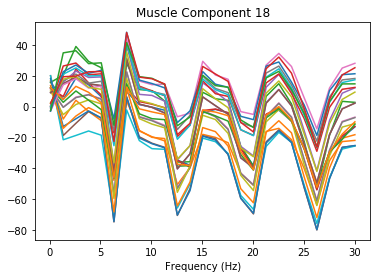

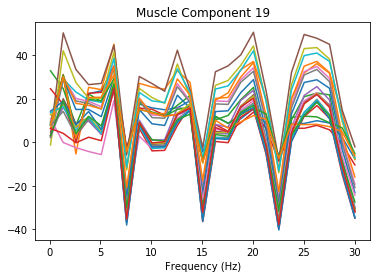

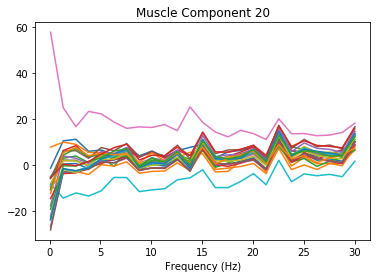

In [10]:
for i in range(0,len(profiles['M'])):
    plt.figure()
    plt.plot(S_labels['f'], factors[:, :, profiles['M'][i]])
    plt.xlabel('Frequency (Hz)')
    plt.title('Muscle Component ' + str(i))
    
for i in range(0,len(profiles['N'])):
    plt.figure()
    plt.plot(S_labels['f'], factors[:, :, profiles['N'][i]])
    plt.xlabel('Frequency (Hz)')
    plt.title('Neuron Component ' + str(i))

plt.show()

In [11]:
#swID = S_labels['allWindows']['windowID']
#cwID = C_labels['allWindows']['windowID']
#wID = np.concatenate((np.array(cwID)[cID], np.array(swID)[sID]), axis=0)

#selFreq = np.concatenate([np.array(profiles['N']), np.array(profiles['M'])])

#f3, ax = plt.subplots(1, len(selFreq), sharex = True, sharey = True)

#dB = [[] for _ in range(0,len(selFreq))]

#muscle = {str(selFreq[0]): []}
#neuron = {str(selFreq[0]): []}
#both = {str(selFreq[0]): []}

#for p in range(0, len(selFreq)):
#    dB[p] = [[] for _ in range(3)]
#    for i in range(0, freqDomain.shape[0]):
#        dB[p][y[i]].append(freqDomain[i, selFreq[p]])

#    muscle[str(selFreq[p])] = dB[p][0]
#    neuron[str(selFreq[p])] = dB[p][2]
#    both[str(selFreq[p])] = dB[p][1]
    
#    ax[p].boxplot(dB[p], whis = 'range')
    
#plt.show()
    
#plt.figure()
#plt.boxplot(muscle.values, whis = 'range')

#plt.figure()
#plt.boxplot(neuron.values, whis = 'range')

#plt.figure()
#plt.boxplot(both.values, whis = 'range')

#plt.show()

        #if y[i] == 0:
        #    ax[y[i]].plot(wID[i], freqDomain[i, selFreq[p]], marker = '.', linestyle = '', color = ('xkcd:'+colors[p]))
        #elif y[i] == 1:
        #    ax[1].plot(wID[i], freqDomain[i, selFreq[p]], marker = '.', linestyle = '', color = ('xkcd:'+colors[p]))
        #elif y[i] == 2:
        #    ax[2].plot(wID[i], freqDomain[i, selFreq[p]], marker = '.', linestyle = '', color = ('xkcd:'+colors[p]))
        #wVec[w[i]].append()
        #fVec[y[i]].append(freqDomain[i, selFreq[p]])
    #print(selFreq[p], colors[p])

#plt.xlim(180, 270)
#ax[0].set_ylabel('Muscle')
#ax[1].set_ylabel('Both')
#ax[2].set_ylabel('Neuron')
#plt.show(f3)

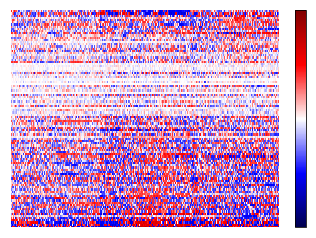

In [12]:
from matplotlib.colors import SymLogNorm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

acd = np.zeros(C)
for cmp in range(0, C):
    acd[cmp] = np.mean(coeff_diff[cmp])

tempMap = [[] for _ in range(0, C)]
heatMap = {0: np.zeros((9, 360, C)), 1: np.zeros((3, 360, C)), 2: np.zeros((3, 360, C))}

for cmp in range(0, C):
    tempMap[cmp] = scores[:, cmp] * acd[cmp]
  
for i in range(0, len(C_labels['allWindows']['subject'])):
    ChR = int('hm' in C_labels['allWindows']['subject'][i])
    d = int(C_labels['allWindows']['subject'][i][6])-1
    w = C_labels['allWindows']['windowID'][i]-1
    if w < 360:
        for cmp in range(0, C):
            heatMap[ChR+1][d, w, cmp] = tempMap[cmp][i]

for i in range(0, len(S_labels['allWindows']['subject'])):
    d = int(S_labels['allWindows']['subject'][i][6])-1
    w = S_labels['allWindows']['windowID'][i]-1
    if w < 360:
        for cmp in range(0, C):
            heatMap[0][d, w, cmp] = tempMap[cmp][i+len(C_labels['allWindows']['subject'])]
            
heatMean = [np.zeros((360, C)), np.zeros((360, C)), np.zeros((360, C))]
bigHeat = np.zeros((360 * 3, C))
bsl = np.zeros((C, 3))
first =[]

for k in range(0, 3): 
    heatMean[k] = (np.array(np.mean(heatMap[k], axis = 0)))
    heatMean[k] = heatMean[k] - np.mean(heatMean[k][range(0, 180), :], axis = 0)
    for cmp in range(0, C):
        first.append(np.mean(heatMean[k][range(0, 180), cmp]))
        #bsl[cmp, k] = np.mean(heatMean[k][range(0, 180), cmp])
        bigHeat[np.arange(360*k, 360*(k+1), dtype = int), cmp] = (heatMean[k][:, cmp])

for cmp in range(0, C):
    bigHeat[:, cmp] = (bigHeat[:, cmp])# - np.mean(np.array(bsl[cmp, :]))

val = (np.mean(bigHeat[range(540, 630), :], axis = 0) 
       - np.mean(bigHeat[range(900, 990), :], axis = 0))
#val = np.mean(bigHeat[range(180, 270), :], axis = 0)
valIndex = np.argsort(val)
magIndex = np.argsort(mag)

temp = np.zeros((1080, C))
for cmp in range(0, C):
    temp[:, cmp] = (bigHeat[:, valIndex[cmp]])
bigHeat = temp

vmin, vmax, lt, ls = -10, 10, 0.01, 2

f, ax = plt.subplots()
plt.imshow(bigHeat.T, aspect = 'auto', cmap = 'seismic', norm = SymLogNorm(linthresh = lt, linscale = ls, vmin = vmin, vmax = vmax))
xlab = [[] for _ in range(np.arange(0, 1081, 90).shape[0])]
for i in range(0, len(xlab)): 
    if i % 2 == 0: xlab[i] = np.arange(0, 181, 15)[i]
    else: xlab[i] = ''
#plt.xticks(np.arange(0, 1081, 90), xlab)
plt.xticks([])
plt.yticks([])
#for i in range(0, 3):
#    plt.plot([270+i*360, 270+i*360], [0, C], color = 'xkcd:dark gray', linestyle = '--')
#    plt.plot([180+i*360, 180+i*360], [0, C], color = 'xkcd:dark gray', linestyle = '--')
#    if i > 0: plt.plot([i*360, i*360], [0, C], color = 'k', lw = 1)
plt.xlim((0, 1080))
plt.ylim((C-1, 0))
#plt.ylabel('Signature')
#plt.xlabel('Time (minutes)')
cbar = plt.colorbar(ticks=[])

plt.savefig("HeatMap.jpg", transparent=True)

plt.box('off')

plt.show()

{'N': array([], dtype=int32), 'M': array([ 9, 11, 15, 18, 29, 38, 39, 40, 42, 46, 48, 52, 53, 55, 57, 59, 62,
       65, 66, 78, 88])}
[9, 11, 15, 18, 29, 38, 39, 40, 42, 46, 48, 52, 53, 55, 57, 59, 62, 65, 66, 78, 88]
10
[84, 97, 9, 17, 12, 96, 5, 59, 63, 87]


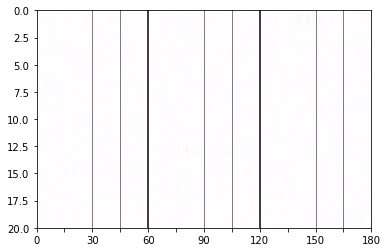

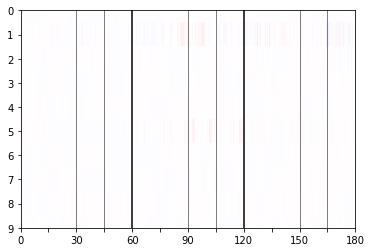

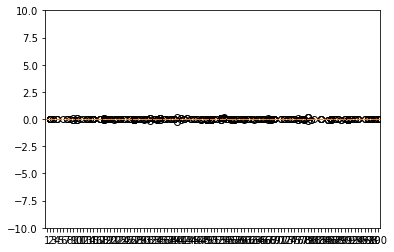

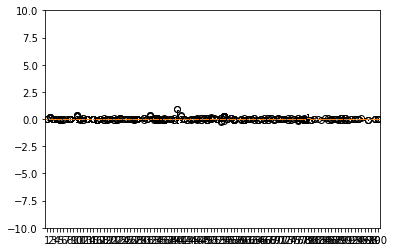

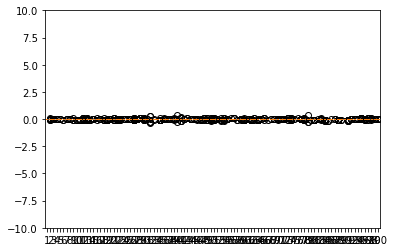

In [13]:
print(profiles)
replot = []
for i in range(0,len(profiles['N'])):
    replot.append(profiles['N'][i])
for i in range(0,len(profiles['M'])):
    replot.append(profiles['M'][i])
print(replot)

    
plt.figure()
plt.imshow(bigHeat[:, replot].T, aspect = 'auto', cmap = 'seismic', vmin = vmin, vmax = vmax)
xlab = [[] for _ in range(np.arange(0, 1081, 90).shape[0])]
for i in range(0, len(xlab)): 
    if i % 2 == 0: xlab[i] = np.arange(0, 181, 15)[i]
    else: xlab[i] = ''
plt.xticks(np.arange(0, 1081, 90), xlab)
for i in range(0, 3):
    plt.plot([270+i*360, 270+i*360], [0, len(replot)], color = 'k', lw = 0.5)
    plt.plot([180+i*360, 180+i*360], [0, len(replot)], color = 'k', lw = 0.5)
    if i > 0: plt.plot([i*360, i*360], [0, C], color = 'k', lw = 1.5)
plt.xlim((0, 1080))
plt.ylim((len(replot)-1, 0))

replot2=[]
v = int(np.round((len(profiles['N']) + len(profiles['M']))/2))
print(v)
for i in range(0, v):
    replot2.append(valIndex[i])
for i in range(len(valIndex), len(valIndex)-v):
    replot2.append(valIndex[i])
print(replot2)

plt.figure()
plt.imshow(bigHeat[:, replot2].T, aspect = 'auto', cmap = 'seismic', vmin = vmin, vmax = vmax)
xlab = [[] for _ in range(np.arange(0, 1081, 90).shape[0])]
for i in range(0, len(xlab)): 
    if i % 2 == 0: xlab[i] = np.arange(0, 181, 15)[i]
    else: xlab[i] = ''
plt.xticks(np.arange(0, 1081, 90), xlab)
for i in range(0, 3):
    plt.plot([270+i*360, 270+i*360], [0, len(replot)], color = 'k', lw = 0.5)
    plt.plot([180+i*360, 180+i*360], [0, len(replot)], color = 'k', lw = 0.5)
    if i > 0: plt.plot([i*360, i*360], [0, C], color = 'k', lw = 1.5)
plt.xlim((0, 1080))
plt.ylim((len(replot2)-1, 0))

for i in range(0, 3):
    plt.figure()
    plt.boxplot(heatMean[i])
    plt.ylim(vmin, vmax)

plt.show()

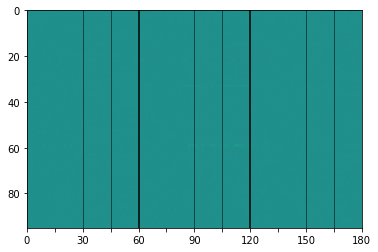

In [14]:
keeper = abs(np.array(first) - np.mean(np.array(first))) < 1.5 * stats.iqr(np.array(first))
keep= dict()
for i in range(0, 3): keep[i] = (keeper[np.arange(i*100, (i+1)*100)])
    
comp = []
for cmp in range(0, C):
    if int(keep[0][cmp]) or int(keep[1][cmp]) or int(keep[2][cmp]):
        comp.append(True)
    else: comp.append(False)
    
plt.figure()
plt.imshow(bigHeat[:, valIndex[comp]].T, aspect = 'auto', cmap = 'viridis', vmin = vmin, vmax = vmax)
xlab = [[] for _ in range(np.arange(0, 1081, 90).shape[0])]
for i in range(0, len(xlab)): 
    if i % 2 == 0: xlab[i] = np.arange(0, 181, 15)[i]
    else: xlab[i] = ''
plt.xticks(np.arange(0, 1081, 90), xlab)
for i in range(0, 3):
    plt.plot([270+i*360, 270+i*360], [0, C], color = 'k', lw = 0.5)
    plt.plot([180+i*360, 180+i*360], [0, C], color = 'k', lw = 0.5)
    if i > 0: plt.plot([i*360, i*360], [0, C], color = 'k', lw = 1.5)
plt.xlim((0, 1080))
plt.ylim((np.sum(comp)-1, 0))

plt.show()

HeatMap 0.pdf
HeatMap 1.pdf
HeatMap 2.pdf


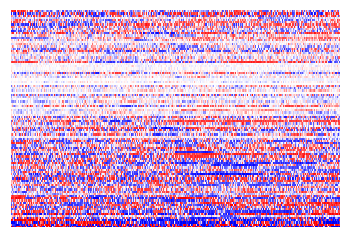

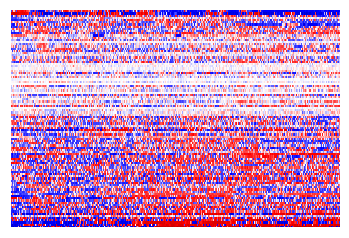

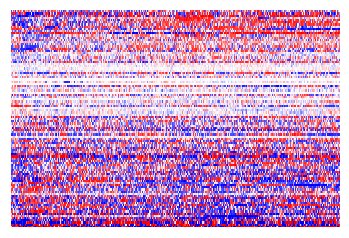

In [15]:
split = [np.zeros((360, C)), np.zeros((360, C)), np.zeros((360, C))]
for k in range(0, 3):
    for cmp in range(0, C):
        split[k][:, cmp] = (heatMean[k][:, valIndex[cmp]])
    
for k in range(0, 3):
    string = "HeatMap " + str(k) + ".pdf"
    print(string)
    f, ax = plt.subplots()
    ax.imshow(split[k].T, aspect = 2.4, cmap = 'seismic', norm = SymLogNorm(linthresh = lt, linscale = ls, vmin = vmin, vmax = vmax))
#    plt.xticks(np.arange(0, 361, 30), xlab)
#    for k in range(0, 3):
#        ax[k].plot([270, 270], [0, C], color = 'k', lw = 1.5)
#        ax[k].plot([180, 180], [0, C], color = 'k', lw = 1.5)
    plt.xlim((0, 359))
    plt.ylim((C-1, 0)) 
    plt.xticks([])   
    plt.yticks([]) 
    plt.box('off')
    plt.savefig(string, transparent=True)
#plt.ylabel('Signature')
#plt.xlabel('Time (minutes)')
plt.show()